### Vamos estruturar nosso modelo para reconhecer gatos e cachorros. 

O dataset usado está disponível em https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [70]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

#Pré-Processar o dataset pode ser um trabalho árduo.
#A variável abaixo irá garantir que nós façamos isso o mínimo possível.
REBUILD_DATA = False

Na classe abaixo definiremos variáveis que serão constantemente utilizadas.

In [71]:
REBUILD_DATA = True # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    #As imagens do dataset possuem dimensões variáveis de uma para a outra
    #Vamos padronizar o tamanho de todas as imagens para facilitar nossa vida
    IMG_SIZE = 50
    
    #Definindo o path da pasta com o dataset
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"

    #Definindo Labels
    LABELS = {CATS: 0, DOGS: 1}
    #Lista que guardará os dados de treino
    training_data = []

    #Contadores para avaliar o balanço de gatos e doggos no dataset
    catcount = 0
    dogcount = 0

    #Vamos criar uma função para criar o dataset de treino
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            #Iterando nas imagens dentro do diretório
            #Obs: o tqdm() só serve pra criar uma barra de progresso bonitinha. Vc Vai ver quando rodar.
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        #Criando o path para carregar a imagem
                        path = os.path.join(label, f)
                        #Carregando a imagem
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        #Reajustando o tamanho da imagem
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        
                        #Adicionando a imagem ao dataset. Obs: Estaremos utilizando onehotvector para os labels
                        #Para converter para onehotvector, utilizamos np.eye()
                        #np.eye() basicamente cria uma matriz identidade do tamanho especificado
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass

        #Embaralhando o dataset
        np.random.shuffle(self.training_data)
        #Salvando o dataset
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)


    

In [72]:
#O rebuild_data ficara setado para falso depois de rodarmos uma vez. 
#Assim não precisaremos carregar o dataset toda vez
if REBUILD_DATA:
    #Cria um objeto da classe
    dogsvcats = DogsVSCats()
    #Trata os dados e salva em "traning_data.npy"
    dogsvcats.make_training_data()
    #Carrega o "training_data.npy"
    training_data = np.load("training_data.npy", allow_pickle=True)

  0%|          | 25/12501 [00:00<00:50, 248.91it/s]

PetImages/Cat


  1%|          | 78/12501 [00:00<00:16, 776.14it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:14<00:00, 867.55it/s]
/home/kodex/anaconda3/envs/pytorch/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Cats: 12476
Dogs: 12470


Veja um como um elemento do training data set parece: Primeiro temos a matriz de pixels 50x50x1 e a seguir temos os labels 0/1 indicando de é gato ou cachorro.

In [73]:
print(training_data[0])

[array([[197, 198, 202, ..., 232, 219, 218],
       [200, 200, 201, ..., 228, 218, 218],
       [202, 200, 202, ..., 229, 218, 218],
       ...,
       [196, 174, 166, ..., 227, 238, 228],
       [166, 191, 221, ..., 200, 193, 147],
       [202, 238, 229, ..., 229, 198, 137]], dtype=uint8)
 array([1., 0.])]


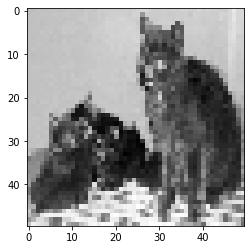

In [74]:
plt.imshow(training_data[0][0], cmap="gray")

# Parte 6
## A seguir, vamos separar os dados em batches e treiná-los.

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#Classe do modelo
class Net(nn.Module):
    def __init__(self):
        #Chamando o init da classe pai
        super().__init__()
        
        #Estruturando as camadas
        
        #O primeiro parâmetro é a entrada da conv layer. Em fully-connected layers, precisaríamos planarizar a 
        #imagem em um único vetor e então passar como entrada o tamanho desse vetor
        #Aqui, a imagem é passada inteira. Desse modo, basta passar 1 como entrada, pq passaremos 1 imagem
        
        #O segundo parâmetro é a saída da conv layer, ou seja, é a quantidade de filtros(kernels) que serão gerados
        #O terceiro parâmetro é o tamanho do filtro(kernel). Nesse caso, teremos 5x5
        #Ou seja, o kernel dessa camada tem dimensões 32x5x5.
        self.conv1 = nn.Conv2d(1, 32, 5)
        
        #Vamos fazer 3 conv layers
        #Conv2 possui um kernel 64x5x5
        self.conv2 = nn.Conv2d(32, 64, 5)
        #Conv3 possui um kernel 128x5x5
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        #Agora vamos usar camadas fully-connected. Para isso, temos que usar o "flatten"
        #Porém, antes, devemos calcular o tamanho disso. 
        #Veja a célula abaixo para mais informações.
        
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))

        #Hora de usar o flatten

        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)

Para descobrirmos qual será o tamanho da saída da 3º conv layer para que possamos usar o flatten, devemos passar dados pela rede uma vez e ver qual é o output. Nessa primeira passagem, comentaremos nossas camadas fully-connected. Desse modo, saberemos o tamanho do output da 3º conv layer.

Outra forma é calcular o tamanho da imagem até chegar na fl layer. O cálculo seria o seguinte:

IMG_SIZE = 50 -> conv1(50 - 5 + 1) -> pool2x2((46-2)/2 +1) -> conv2(23 - 5 + 1) -> pool2x2((19-2)/2+1) -> conv3(9 - 5 + 1) -> pool2x2((5-2)/2+1) = 2

2 * 2 * 128 = 512. 

In [90]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [95]:
#Criando o optimizer
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [96]:
#Separando as features e labels do training_set
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
#Normalizando o valor do pixels da imagem
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

#Separando training e test sets
VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print("Tamanho do test set: ", val_size)

Tamanho do test set:  2494


In [97]:
#Pega de 0 até final-val_size
train_X = X[ : -val_size]
train_y = y[ : -val_size]

#Pega de final-val_size até final
test_X = X[-val_size :]
test_y = y[-val_size :]

print("Treino:", len(train_X))
print("Teste:", len(test_X))

Treino: 22452
Teste: 2494


In [101]:
BATCH_SIZE = 100
EPOCHS = 10

for epoch in range(EPOCHS):
    #Começa em zero e vai até o final do training set, pulando BATCH_SIZE a cada iteração
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): 
        
        #Separa os batches
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        #Zerando o gradiente para a loss não acumular durante o treinamento
        net.zero_grad()

        #Forward prop
        outputs = net(batch_X)
        #Calcula o custo
        loss = loss_function(outputs, batch_y)
        #Backward prop
        loss.backward()
        #Atualiza os pesos
        optimizer.step()   
        
    print(f"Epoch: {epoch}. Loss: {loss}")
        

  0%|          | 1/225 [00:00<00:43,  5.17it/s]

Epoch: 0. Loss: 0.13052375614643097


  0%|          | 1/225 [00:00<00:42,  5.27it/s]

Epoch: 1. Loss: 0.09235759824514389


  0%|          | 1/225 [00:00<00:43,  5.18it/s]

Epoch: 2. Loss: 0.06425964832305908


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 3. Loss: 0.033150896430015564


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch: 4. Loss: 0.12489456683397293


  0%|          | 1/225 [00:00<00:42,  5.28it/s]

Epoch: 5. Loss: 0.060841210186481476


 10%|█         | 23/225 [00:04<00:38,  5.20it/s]


KeyboardInterrupt: 

In [102]:
#Avaliando o modelo
correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))
        predicted_class = torch.argmax(net_out)
        
        if(predicted_class == real_class):
            correct += 1
        total += 1
      
    print("Accuracy: ", round(correct/total, 3))

100%|██████████| 2494/2494 [00:03<00:00, 651.79it/s]

Accuracy:  0.73
